# ZUM: Projekt 1 - Kalkulator głosowy
Studenci: Gabriela Szczesna [s17158], Juliusz Stańczyk [s24206]

## 1. Pobranie próbek dźwięku

In [ ]:
!wget http://users.pja.edu.pl/~s17158/nagrania/nagrania.tar.gz
!tar xvf nagrania.tar.gz

--2022-11-02 14:14:35--  http://users.pja.edu.pl/~s17158/nagrania/nagrania.tar.gz
Resolving users.pja.edu.pl (users.pja.edu.pl)... 91.230.222.21, 2001:67c:23f4::ab00
Connecting to users.pja.edu.pl (users.pja.edu.pl)|91.230.222.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9650376 (9.2M) [application/x-gzip]
Saving to: ‘nagrania.tar.gz’

nagrania.tar.gz     100%[===================>]   9.20M  2.59MB/s    in 3.6s    

2022-11-02 14:14:39 (2.59 MB/s) - ‘nagrania.tar.gz’ saved [9650376/9650376]

._nagrania
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
nagrania/
nagrania/Juliusz_part1.wav
nagrania/Juliusz_part2.wav
nagrania/Juliusz_part3.wav
nagrania/Juliusz_part7.wav
nagrania/._.DS_Store
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
nagrania/.DS_Store
nagrania/Juliusz_part6.wav
nagrania/Juliusz_part4.wav
nagrania/Juliusz_part5.wav
nagrania/._text.txt
tar: Ignoring unknown extended 

## 2. Pobranie bibliotek

In [ ]:
!pip install https://github.com/huggingface/transformers/archive/refs/heads/master.zip
!pip install https://github.com/kensho-technologies/pyctcdecode/archive/refs/heads/main.zip
!pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install wavio
!pip install jiwer
!pip install arpa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 13.6 MB 5.4 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 7.6 MB 34.4 MB/s 
     |████████████████████████████████| 163 kB 69.9 MB/s 
  Created wheel for transformers: filename=transformers-4.24.0.dev0-py3-none-any.whl size=5429263 sha256=89b3168410c3b27a6f362ffb99c366408008d73b77d4f06b2254af452eff7395
  Stored in directory: /tmp/pip-ephem-wheel-cache-qrfjoi76/wheels/92/7e/03/a16a3d5eb8a53365edd738b739018eb170666f47b01a1776ad
Successfully built transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 217 kB 170 kB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 395 kB 56.5 MB/s 
 

In [ ]:
!wget http://users.pja.edu.pl/~danijel/zum/srilm-bin.tar.xz
!tar xvf srilm-bin.tar.xz
!ln -sf ${PWD}/bin/i686-m64/ngram /usr/local/bin/ngram
!ln -sf ${PWD}/bin/i686-m64/ngram-count /usr/local/bin/ngram-count

--2022-10-30 23:03:40--  http://users.pja.edu.pl/~danijel/zum/srilm-bin.tar.xz
Resolving users.pja.edu.pl (users.pja.edu.pl)... 91.230.222.21, 2001:67c:23f4::ab00
Connecting to users.pja.edu.pl (users.pja.edu.pl)|91.230.222.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37056672 (35M) [application/x-xz]
Saving to: ‘srilm-bin.tar.xz’

srilm-bin.tar.xz    100%[===================>]  35.34M  7.68MB/s    in 8.2s    

2022-10-30 23:03:49 (4.32 MB/s) - ‘srilm-bin.tar.xz’ saved [37056672/37056672]

bin/
bin/merge-batch-counts
bin/make-batch-counts
bin/compute-sclite-nbest
bin/pfsg-from-ngram
bin/rescore-acoustic
bin/nbest-error
bin/search-rover-combo
bin/rexport.gnumake
bin/make-multiword-pfsg
bin/rescore-minimize-wer
bin/rescore-reweight
bin/i686-m64/
bin/i686-m64/sentid-to-sclite
bin/i686-m64/reverse-lm
bin/i686-m64/select-vocab
bin/i686-m64/subset-context-ngrams
bin/i686-m64/maxalloc
bin/i686-m64/make-kn-counts
bin/i686-m64/wlat-to-pfsg
bin/i686-m64/wlat-stats


In [ ]:
%pylab inline

from pathlib import Path
from tqdm import tqdm

import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from pyctcdecode import build_ctcdecoder
from wavio import read
import jiwer
import arpa

Populating the interactive namespace from numpy and matplotlib


## 3. Instalacja modeli


In [ ]:
processor=Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-10k-voxpopuli-ft-pl')
model=Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-10k-voxpopuli-ft-pl').to('cuda')

Downloading:   0%|          | 0.00/213 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/138 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

## 4. Wczytanie plików audio

In [ ]:
files={}
for f in Path('nagrania').glob('*.wav'):
  try:
    data=read(str(f))
    files[f.stem]=data.data.squeeze().astype('float32')
  except Exception as e:
    print(str(f), e)
    pass

Długości plików audio:

In [ ]:
Fs=data.rate
for name,d in files.items():
  print(f'{name}: {d.size/Fs:0.2f}s')

Juliusz_part3: 46.65s
Juliusz_part5: 44.64s
Juliusz_part1: 45.81s
Juliusz_part4: 44.64s
Juliusz_part2: 44.88s
Juliusz_part10: 40.14s
Juliusz_part6: 44.64s
Juliusz_part9: 39.97s
Juliusz_part8: 44.17s
Juliusz_part7: 43.34s


Przykładowa próbka dźwięku

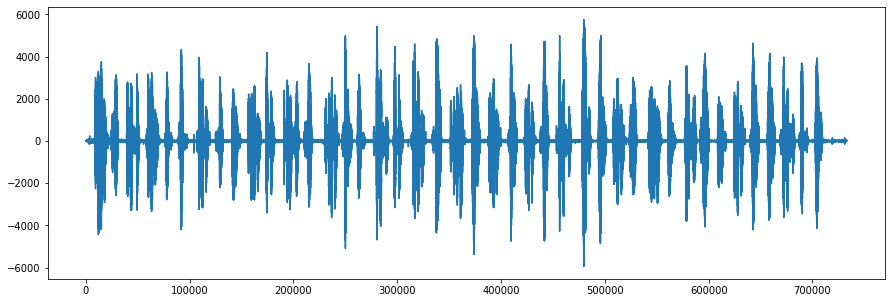

In [ ]:
figure(figsize=(15,5))
plot(files['Juliusz_part1'])

## 5. Przetwarzanie podstawowym modelem ASR

In [ ]:
# %env 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256'

env: 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256'


In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True).to('cuda')
  out=model(input_values=feats.input_values)
  predicted_ids=torch.argmax(out.logits,dim=-1)
  sent=processor.batch_decode(predicted_ids)[0]
  trans[name]=sent

100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


In [ ]:
trans

{'Juliusz_part3': 'sześćdziesiąt pięć sześćdziesiąt minus dziewięć dwadzieścia siedemdziesiąt lus siedem dwadzieścia jedem osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem tszedzieści razy trzy dwadzieścia osiem lus dwadzieścia trzy sześdziesiąt trzy siedemdziesiąt lus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć mius dwadzieścia dziesięć',
 'Juliusz_part5': 'siedemdziesiąt dwa minus sześćdziesiąt osiem lus trzydzieści siedem dziewięćdziesiąt cztery lu siedemdziesiąt cztery siedemnaście siedemdziesiąt razy osiem dziewięć minus siedemdziesiąt siedem osiemnaście razy czterdzieści dziewięć czterdzieści tzy trzydzieści dwa jedem czterdzieści pięć zternaście dziewięćdzisiąt osiem szesnaście trzydzieści osiemdziesiąt jeden minus',
 'Juliusz_part1': 'osiemdziesiąt trzy piednaście sześćdziesiąt ls sześć sześćdziesiąt trzy minus osiemdziesiąt osiem osiemnaście trzy osiemdziesiąt siedem lus czterdzieści osiem siedemdziesiąt cztery osiemdzi

## 6. Weryfikacja jakości

In [ ]:
ref={}
with open('nagrania/text.txt') as f:
  for l in f:
    tok=l.strip().split()
    ref[tok[0]]=' '.join(tok[1:])

In [ ]:
h=[]
r=[]

for name in trans.keys():
  print(f'>>{name}')
  print(trans[name])
  print(ref[name])
  print('')

  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

>>Juliusz_part3
sześćdziesiąt pięć sześćdziesiąt minus dziewięć dwadzieścia siedemdziesiąt lus siedem dwadzieścia jedem osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem tszedzieści razy trzy dwadzieścia osiem lus dwadzieścia trzy sześdziesiąt trzy siedemdziesiąt lus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć mius dwadzieścia dziesięć
sześćdziesiąt pięć sześćdziesiąt minus dziewięć dwanaście siedemdziesiąt plus siedem dwadzieścia jeden osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem trzydzieści razy trzy dwadzieścia osiem plus dwadzieścia trzy sześćdziesiąt trzy siedemdziesiąt plus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć minus dwadzieścia dziesięć

>>Juliusz_part5
siedemdziesiąt dwa minus sześćdziesiąt osiem lus trzydzieści siedem dziewięćdziesiąt cztery lu siedemdziesiąt cztery siedemnaście siedemdziesiąt razy osiem dziewięć minus siedemdziesiąt siedem osiemnaście r

## 7. Model języka do rozpoznawania ciągów liczb

In [ ]:
digits_short=['zero','jeden','dwa','trzy','cztery','pięć','sześć','siedem','osiem','dziewięć']
with open('digits_short.txt','w') as f:
  for l in range(100):
    f.write(' '.join([digits_short[x] for x in randint(0,10,10)])+'\n')

In [ ]:
!head -n 10 digits_short.txt

sześć pięć dwa sześć jeden sześć zero zero sześć osiem
dziewięć sześć osiem dwa pięć dziewięć dwa dziewięć cztery pięć
zero dziewięć dwa sześć zero siedem siedem jeden dwa trzy
pięć dziewięć dwa trzy pięć osiem sześć cztery dziewięć jeden
siedem dziewięć osiem siedem jeden dziewięć osiem jeden jeden siedem
jeden dziewięć dwa zero jeden siedem dziewięć osiem cztery zero
siedem jeden sześć pięć dziewięć osiem dziewięć trzy cztery jeden
jeden sześć jeden jeden osiem zero sześć sześć dziewięć dwa
pięć pięć jeden jeden siedem sześć cztery zero sześć dziewięć
osiem osiem dwa siedem dwa trzy trzy siedem dziewięć trzy


Zrób z tego pliku model języka `digits.arpa`:

In [ ]:
!ngram-count -text digits_short.txt -order 3 -wbdiscount -unk -lm digits_short.arpa

Sprawdź losowe ciągi z tego modelu - czy odpowiadają temu czego się spodziewamy:

In [ ]:
!ngram -lm digits_short.arpa -unk -gen 10

dwa dziewięć trzy
dwa dziewięć dwa zero <unk> jeden trzy cztery trzy zero osiem siedem sześć cztery zero jeden dwa dziewięć trzy cztery dwa pięć cztery <unk> cztery zero siedem dwa sześć dziewięć jeden jeden pięć zero dziewięć sześć siedem osiem sześć <unk> osiem

jeden cztery
dziewięć dwa
cztery jeden trzy osiem trzy <unk>
trzy siedem zero trzy <unk> trzy dziewięć <unk> dziewięć
siedem dziewięć zero osiem osiem

osiem


## 8. Dekodowanie wygenerowanym modelem języka

Użyj `processor.tokenizer.get_vocab()` żeby dostać posortowaną (wg identyfikatorów) listę tokenów w modelu. Zamień separator słów (token `'|'`) na spację:

In [ ]:
tokens=[x[0] for x in sorted(processor.tokenizer.get_vocab().items(),key=lambda x:x[1])]
print(tokens)
tokens[4]=' '
print(tokens)

['<pad>', '<s>', '</s>', '<unk>', '|', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']
['<pad>', '<s>', '</s>', '<unk>', ' ', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']


Użyj metody `build_ctcdecoder` żeby storzyć dekoder - podaj listę tokenów, plik ARPA oraz parametry `alpha=2.0` oraz `beta=-1.0`:

In [ ]:
decoder=build_ctcdecoder(tokens,'digits_short.arpa',alpha=2.0,beta=-1.0)

Powtórz proces dekodowania, ale zamiast liczyć `torch.argmax` przekaż wynik modelu do decodera. Metoda `decoder.decode` potrzebuje listy w postaci NumPy, więc trzeba ją zamienić używając poleceń: `out.logits.cpu().detach().numpy()`:

In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True).to('cuda')
  out=model(input_values=feats.input_values)
  sent=decoder.decode(out.logits.cpu().detach().numpy()[0])
  trans[name]=sent

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Na samym końcu, wyświetl wyniki i ponownie wylicz WER:

In [ ]:
h=[]
r=[]

for name in trans.keys():
  print(f'>>{name}')
  print(trans[name])
  print(ref[name])
  print('')

  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

>>Juliusz_part3
sześćdziesiątpięćsześćdziesiątminus dziewięć dwadzieściaw siedemdziesiątlus siedem dwadzieściajedem osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem tszedzieści razy trzy dwadzieścia osiem dwadzieścia trzy sześdziesiąt trzy siedemdziesiątlus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć minus dwadzieściadziesięć
sześćdziesiąt pięć sześćdziesiąt minus dziewięć dwanaście siedemdziesiąt plus siedem dwadzieścia jeden osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem trzydzieści razy trzy dwadzieścia osiem plus dwadzieścia trzy sześćdziesiąt trzy siedemdziesiąt plus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć minus dwadzieścia dziesięć

>>Juliusz_part5
siedemdziesiątdwaminus sześćdziesiąt osiem trzydzieści siedem dziewięćdziesiąt cztery siedemdziesiąt cztery siedemnaście siedemdziesiąt razy osiem dziewięć minus siedemdziesiąt siedem osiemnaście razy czterdzieści d

Podsumowanie Word error rate (WER): 0.35910224438902744

## 9. Optymalizacja procesu

### 9.1 Rożne modele języka

#### 9.1.1 Model rozszerzony
Model ten został rozszerzony z zakresu 0-9 do 0-20 + co dziesiąte wartości typu 30, 40 etc.

In [ ]:
digits_long=['zero','jeden','dwa','trzy','cztery','pięć','sześć','siedem','osiem','dziewięć', 'dziesięć', 'jedenaście', 'dwanaście', 'trzynaście', 'czternaście', 'piętnaście', 'szesnaście', 'siedemnaście', 'osiemnaście', 'dziewiętnaście', 'dwadzieścia', 'trzydzieści', 'czterdzieści', 'pięćdzisiąt', 'sześćdziesiąt', 'siedemdziesiąt', 'osiemdziesiąt', 'dzięwięćdziesiąt', 'sto']
with open('digits_long.txt','w') as f:
  for l in range(100):
    f.write(' '.join([digits_long[x] for x in randint(0,10,10)])+'\n')

In [ ]:
!ngram-count -text digits_long.txt -order 3 -wbdiscount -unk -lm digits_long.arpa

In [ ]:
tokens=[x[0] for x in sorted(processor.tokenizer.get_vocab().items(),key=lambda x:x[1])]
print(tokens)
tokens[4]=' '
print(tokens)

['<pad>', '<s>', '</s>', '<unk>', '|', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']
['<pad>', '<s>', '</s>', '<unk>', ' ', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']


In [ ]:
decoder=build_ctcdecoder(tokens,'digits_long.arpa',alpha=2.0,beta=-1.0)

In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True).to('cuda')
  out=model(input_values=feats.input_values)
  sent=decoder.decode(out.logits.cpu().detach().numpy()[0])
  trans[name]=sent

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


In [ ]:
h=[]
r=[]

for name in trans.keys():
  print(f'>>{name}')
  print(trans[name])
  print(ref[name])
  print('')

  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

>>Juliusz_part3
sześćdziesiątpięćsześćdziesiątminus dziewięć dwadzieściaw siedemdziesiątlus siedem dwadzieściajedem osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem tszedzieści razy trzy dwadzieścia osiem dwadzieścia trzy sześdziesiąt trzy siedemdziesiątlus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć minus dwadzieściadziesięć
sześćdziesiąt pięć sześćdziesiąt minus dziewięć dwanaście siedemdziesiąt plus siedem dwadzieścia jeden osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem trzydzieści razy trzy dwadzieścia osiem plus dwadzieścia trzy sześćdziesiąt trzy siedemdziesiąt plus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć minus dwadzieścia dziesięć

>>Juliusz_part5
siedemdziesiątdwaminus sześćdziesiąt osiem trzydzieści siedem dziewięćdziesiąt cztery siedemdziesiąt cztery siedemnaście siedemdziesiąt razy osiem dziewięćminus siedemdziesiąt siedem osiemnaście razy czterdzieści dz

Podsumowanie Word error rate (WER): 0.3640897755610973

#### 9.1.2 Model z nazwami operacji
Jest to model rozszerzony w poprzedniego punktu z dodanymi nazwami operacji taki jak 'plus', 'minus' i 'razy'.

In [ ]:
digits_op=['plus', 'minus', 'razy', 'zero','jeden','dwa','trzy','cztery','pięć','sześć','siedem','osiem','dziewięć', 'dziesięć', 'jedenaście', 'dwanaście', 'trzynaście', 'czternaście', 'piętnaście', 'szesnaście', 'siedemnaście', 'osiemnaście', 'dziewiętnaście', 'dwadzieścia', 'trzydzieści', 'czterdzieści', 'pięćdzisiąt', 'sześćdziesiąt', 'siedemdziesiąt', 'osiemdziesiąt', 'dzięwięćdziesiąt', 'sto']
with open('digits_op.txt','w') as f:
  for l in range(100):
    f.write(' '.join([digits_op[x] for x in randint(0,10,10)])+'\n')

In [ ]:
!ngram-count -text digits_op.txt -order 3 -wbdiscount -unk -lm digits_op.arpa

In [ ]:
tokens=[x[0] for x in sorted(processor.tokenizer.get_vocab().items(),key=lambda x:x[1])]
print(tokens)
tokens[4]=' '
print(tokens)

['<pad>', '<s>', '</s>', '<unk>', '|', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']
['<pad>', '<s>', '</s>', '<unk>', ' ', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']


In [ ]:
decoder=build_ctcdecoder(tokens,'digits_op.arpa',alpha=2.0,beta=-1.0)

In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True).to('cuda')
  out=model(input_values=feats.input_values)
  sent=decoder.decode(out.logits.cpu().detach().numpy()[0])
  trans[name]=sent

100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


In [ ]:
h=[]
r=[]

for name in trans.keys():
  print(f'>>{name}')
  print(trans[name])
  print(ref[name])
  print('')

  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

>>Juliusz_part3
sześćdziesiątpięćsześćdziesiąt minus dziewięć dwadzieściaw siedemdziesiątlus siedem dwadzieściajedem osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem tszedzieści razy trzy dwadzieścia osiemlus dwadzieścia trzy sześdziesiąt trzy siedemdziesiątlus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć minus dwadzieściadziesięć
sześćdziesiąt pięć sześćdziesiąt minus dziewięć dwanaście siedemdziesiąt plus siedem dwadzieścia jeden osiem osiemdziesiąt jeden czterdzieści razy trzy czterdzieści sześć osiemdziesiąt osiem trzydzieści razy trzy dwadzieścia osiem plus dwadzieścia trzy sześćdziesiąt trzy siedemdziesiąt plus sześć dziewięćdziesiąt cztery osiemdziesiąt pięćdziesiąt sześć minus dwadzieścia dziesięć

>>Juliusz_part5
siedemdziesiątdwaminus sześćdziesiąt osiemlus trzydzieści siedem dziewięćdziesiąt cztery siedemdziesiąt cztery siedemnaście siedemdziesiąt razy osiem dziewięćminus siedemdziesiąt siedem osiemnaście razy czterdzi

Word error rate (WER) dla modelu digits_short: 0.35910224438902744

Word error rate (WER) dla modelu digits_long: 0.3640897755610973

Word error rate (WER) dla modelu digits_op: 0.3740648379052369

### 9.2 Rożne parametry dekodera

#### 9.2.1 Alpha = 0.5, Beta = 1.0

In [ ]:
digits_op=['plus', 'minus', 'razy', 'zero','jeden','dwa','trzy','cztery','pięć','sześć','siedem','osiem','dziewięć', 'dziesięć', 'jedenaście', 'dwanaście', 'trzynaście', 'czternaście', 'piętnaście', 'szesnaście', 'siedemnaście', 'osiemnaście', 'dziewiętnaście', 'dwadzieścia', 'trzydzieści', 'czterdzieści', 'pięćdzisiąt', 'sześćdziesiąt', 'siedemdziesiąt', 'osiemdziesiąt', 'dzięwięćdziesiąt', 'sto']
with open('digits_op.txt','w') as f:
  for l in range(100):
    f.write(' '.join([digits_op[x] for x in randint(0,10,10)])+'\n')

In [ ]:
!ngram-count -text digits_op.txt -order 3 -wbdiscount -unk -lm digits_op.arpa

In [ ]:
tokens=[x[0] for x in sorted(processor.tokenizer.get_vocab().items(),key=lambda x:x[1])]
print(tokens)
tokens[4]=' '
print(tokens)

['<pad>', '<s>', '</s>', '<unk>', '|', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']
['<pad>', '<s>', '</s>', '<unk>', ' ', 'e', 'a', 'i', 'o', 'n', 'z', 'r', 'w', 's', 't', 'c', 'y', 'p', 'd', 'k', 'm', 'j', 'u', 'l', 'b', 'g', 'ł', 'h', 'ą', 'ę', 'ż', 'ó', 'ś', 'ć', 'f', 'ń', 'ź', 'v', 'x', 'q', '1']


In [ ]:
decoder=build_ctcdecoder(tokens,'digits_op.arpa',alpha=0.5,beta=1.0)

In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True).to('cuda')
  out=model(input_values=feats.input_values)
  sent=decoder.decode(out.logits.cpu().detach().numpy()[0])
  trans[name]=sent

100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


In [ ]:
h=[]
r=[]

for name in trans.keys():
  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

{'wer': 0.08977556109725686, 'mer': 0.08977556109725686, 'wil': 0.16524643165954456, 'wip': 0.8347535683404554, 'hits': 365, 'substitutions': 33, 'deletions': 3, 'insertions': 0}


Word error rate (WER) dla pierwszej kombinacji parametrów dekodera: 0.08977556109725686

#### 9.2.1 Alpha = 0.5, Beta = 1.0 i hotwords

In [ ]:
digits_op=['plus', 'minus', 'razy', 'zero','jeden','dwa','trzy','cztery','pięć','sześć','siedem','osiem','dziewięć', 'dziesięć', 'jedenaście', 'dwanaście', 'trzynaście', 'czternaście', 'piętnaście', 'szesnaście', 'siedemnaście', 'osiemnaście', 'dziewiętnaście', 'dwadzieścia', 'trzydzieści', 'czterdzieści', 'pięćdzisiąt', 'sześćdziesiąt', 'siedemdziesiąt', 'osiemdziesiąt', 'dzięwięćdziesiąt', 'sto']
with open('digits_op.txt','w') as f:
  for l in range(100):
    f.write(' '.join([digits_op[x] for x in randint(0,10,10)])+'\n')

In [ ]:
!ngram-count -text digits_op.txt -order 3 -wbdiscount -unk -lm digits_op.arpa

In [ ]:
tokens=[x[0] for x in sorted(processor.tokenizer.get_vocab().items(),key=lambda x:x[1])]
tokens[4]=' '

In [ ]:
hotwords = ['plus', 'minus', 'razy']
decoder=build_ctcdecoder(tokens,'digits_op.arpa',alpha=0.5,beta=1.0)

In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor(data,sampling_rate=Fs,return_tensors='pt',padding=True).to('cuda')
  out=model(input_values=feats.input_values)
  sent=decoder.decode(out.logits.cpu().detach().numpy()[0], hotwords=hotwords, hotword_weight=10.0)
  trans[name]=sent

100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


In [ ]:
h=[]
r=[]

for name in trans.keys():
  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

{'wer': 0.08229426433915212, 'mer': 0.08208955223880597, 'wil': 0.1553392637808464, 'wip': 0.8446607362191536, 'hits': 369, 'substitutions': 32, 'deletions': 0, 'insertions': 1}


Word error rate (WER) dla drugiej kombinacji parametrów dekodera: 0.08229426433915212

### 9.3 Inne modele z serwisu Huggingface

Model: **HuBERT: Self-Supervised Speech Representation Learning by Masked Prediction of Hidden Units**

In [ ]:
#processor2 =Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-10k-voxpopuli-ft-pl')
#model2 =Wav2Vec2ForCTC.from_pretrained('facebook/wav2vec2-base-10k-voxpopuli-ft-pl').to('cuda')
from transformers import Wav2Vec2Processor, HubertModel

processor2 = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
model2 = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")

Downloading:   0%|          | 0.00/212 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/138 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-large-ls960-ft were not used when initializing HubertModel: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
files={}
for f in Path('nagrania').glob('*.wav'):
  try:
    data=read(str(f))
    files[f.stem]=data.data.squeeze().astype('float32')
  except Exception as e:
    print(str(f), e)
    pass

In [ ]:
Fs=data.rate

In [ ]:
trans={}
for name,data in tqdm(files.items()):
  feats=processor2(data,sampling_rate=Fs,return_tensors='pt',padding=True)
  out=model2(input_values=feats.input_values)
  predicted_ids=torch.argmax(out.logits,dim=-1)
  sent=processor2.batch_decode(predicted_ids)[0]
  trans[name]=sent

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
ref={}
with open('nagrania/text.txt') as f:
  for l in f:
    tok=l.strip().split()
    ref[tok[0]]=' '.join(tok[1:])

In [ ]:
h=[]
r=[]

for name in trans.keys():

  h.append(trans[name])
  r.append(ref[name])

print(jiwer.compute_measures(r,h))

# Praca domowa

## - na ocenę 3

Zastosuj powyższe rozwiązanie na swoich nagraniach i wyświetl wyniki.

## - na ocenę 4

Dokonaj optymalizacji procesu w celu polepszenia wyniku (pokaż ile się udało poprawić). Spróbuj następujące rzeczy:

- różne modele języka
- różne parametry dekodera
- inne modele z serwisu Huggingface

## - na ocenę 5

Połącz wynik rozpoznawania mowy z jakimś innym rozwiązaniem albo aplikacją.

Na przykład: 
* zrób prosty kalkulator głosowy
* zrób demonstracyjny dialog do zamawiania pizzy
* połącz rozwiązanie z jakimś innym modelem NLP

Rzuć okiem na https://huggingface.co/tasks oraz https://github.com/jonatasgrosman/huggingsound
